In [1]:
import os
from os.path import isfile,join

import numpy as np
import matplotlib.pyplot as plt
import re

import cv2

In [2]:
frames = os.listdir('frames/')
frames.sort(key=lambda frame: int(re.sub('\D','',frame)))

images = []

for frame in frames:
    img = cv2.imread('frames/'+frame)
    images.append(img)

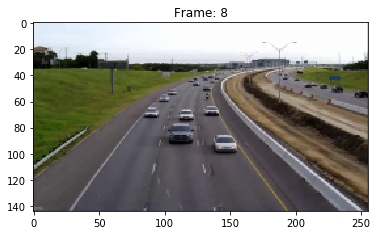

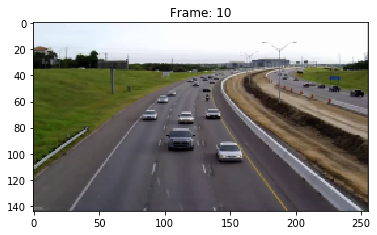

In [3]:
i = 8

for frame in [i,i+2]:
    plt.imshow(cv2.cvtColor(images[frame],cv2.COLOR_BGR2RGB))
    plt.title(f"Frame: {frame}")
    plt.savefig(f'plots/frame{frame}.png')
    plt.show()


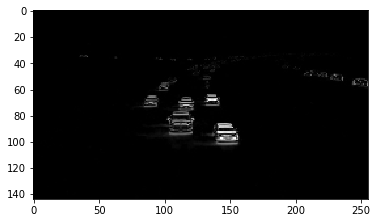

In [4]:
# to see the difference between two of the frames

grayscaleA = cv2.cvtColor(images[i],cv2.COLOR_BGR2GRAY)
grayscaleB = cv2.cvtColor(images[i+1],cv2.COLOR_BGR2GRAY)

plt.imshow(cv2.absdiff(grayscaleB,grayscaleA),cmap='gray')
plt.savefig(f'plots/diff_grayscale.png')
plt.show()

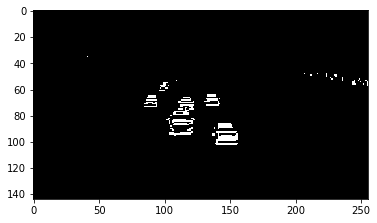

In [5]:
# image thresholding

absdiff_image = cv2.absdiff(grayscaleB,grayscaleA)
ret,thresh_image = cv2.threshold(absdiff_image,30,255,cv2.THRESH_BINARY)

plt.imshow(thresh_image,cmap='gray')
plt.savefig(f'plots/image_thresholding.png')
plt.show()

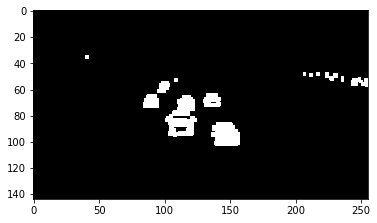

In [6]:
# image dilation

kernel = np.ones((3,3),np.uint8)
dilated_image = cv2.dilate(thresh_image,kernel,iterations=1) #increase of iterations just increases dilation

plt.imshow(dilated_image,cmap='gray')
plt.savefig(f'plots/image_dilation_gray.png')
plt.show()

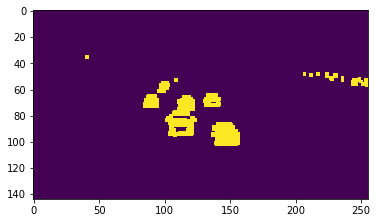

In [7]:
plt.imshow(dilated_image)
cv2.line(dilated_image,(0,80),(256,80),(100,0,0))
plt.savefig(f'plots/image_dilation_default.png')
plt.show()

In [8]:
contours, hierarchy = cv2.findContours(thresh_image.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

valid_contours = []

for i,cntr in enumerate(contours):
    x,y,w,h = cv2.boundingRect(cntr)
    if(x<=200)&(y>=80)&(cv2.contourArea(cntr)>=25):
        valid_contours.append(cntr)
        
len(valid_contours)

5

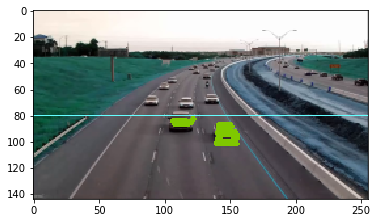

In [9]:
dmy = images[8].copy()

cv2.drawContours(dmy,valid_contours,-1,(127,200,0),2)
cv2.line(dmy,(0,80),(256,80),(100,255,255))
plt.imshow(dmy)
plt.savefig('plots/contour.png')
plt.show()

In [10]:
# combining individual changes over all the frames

kernel = np.ones((4,4),np.uint8)
font = cv2.FONT_HERSHEY_SIMPLEX

for i in range(len(images)-1):
    
    grayscaleA = cv2.cvtColor(images[i],cv2.COLOR_BGR2GRAY)
    grayscaleB = cv2.cvtColor(images[i+1],cv2.COLOR_BGR2GRAY)
    
    absdiff_image = cv2.absdiff(grayscaleB,grayscaleA)
    ret,thresh_image = cv2.threshold(absdiff_image,30,255,cv2.THRESH_BINARY)
    dilated_image = cv2.dilate(thresh_image,kernel,iterations = 1)
    
    contours, hierarchy = cv2.findContours(dilated_image.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    
    valid_contours = []
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        if (x<=200)&(y>=80) &(cv2.contourArea(cntr)>=25):
            if (y>=90)&(cv2.contourArea(cntr)<40):
                break
            valid_contours.append(cntr)
            
    dmy = images[i].copy()
    cv2.drawContours(dmy,valid_contours,-1,(127,200,0),2)
    
    cv2.putText(dmy,f'Vehicles Detected: {len(valid_contours)}',(35,15),font,0.6,(0,180,0),2)
    cv2.line(dmy,(0,80),(256,80),(100,255,255))
    cv2.imwrite(f"detection_frames/{i}.png",dmy)

In [12]:
FPS = 15.0
frames_array = []

files = [f for f in os.listdir('detection_frames/') if isfile(join('detection_frames/',f))]
files.sort(key=lambda file: int(re.sub('\D','',file)))

for i in range(len(files)):
    img = cv2.imread(f'detection_frames/{files[i]}')
    h,w,l = img.shape
    size = (w,h)
    
    frames_array.append(img)
    
out = cv2.VideoWriter(f'detection_video/vehicle_detection.mp4',cv2.VideoWriter_fourcc(*'DIVX'),FPS,size)

for i in range(len(frames_array)):
    out.write(frames_array[i])
    
out.release()